In [54]:
import os 
from glob import glob
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import img_to_array
import cv2 
import numpy as np 
# from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [71]:
data_path = 'simple_recon/data/archive/dataset'
train_path = os.path.join(data_path, 'train')
test_path = os.path.join(data_path, 'val')

train_low_path = os.path.join(train_path, 'low_res')
train_high_path = os.path.join(train_path, 'high_res')
test_low_path = os.path.join(test_path, 'low_res')
test_high_path = os.path.join(test_path, 'high_res')


In [72]:
train_path + '/*.png'

'simple_recon/data/archive/dataset\\train/*.png'

In [73]:
train_low_images = glob(train_low_path + '/*.png')
train_high_images = glob(train_high_path + '/*.png')

test_low_images = glob(test_low_path + '/*.png')
test_high_images = glob(test_high_path + '/*.png')

In [74]:
# type(train_low_images)
# train_low_images111 = np.reshape(train_low_images, (len(train_low_images), 256, 256, 3))
low_train_images = [] 
high_train_images = [] 

for low in train_low_images: 
    img = cv2.imread(low) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))
    img = img.astype('float32') / 255.
    low_train_images.append(img_to_array(img))
    
    
for high in train_high_images: 
    img = cv2.imread(low)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256)) 
    img = img.astype('float32') / 255. 
    high_train_images.append(img_to_array(img))
    


In [75]:
low_test_images = [] 
high_test_images = [] 

for low in test_low_images: 
    img = cv2.imread(low) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))
    img = img.astype('float32') / 255.
    low_test_images.append(img_to_array(img))
    
    
for high in test_high_images: 
    img = cv2.imread(low)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256)) 
    img = img.astype('float32') / 255. 
    high_test_images.append(img_to_array(img))
    

In [76]:
low_train_images = np.reshape(low_train_images, (len(low_train_images), 256, 256, 3))
high_train_images = np.reshape(high_train_images, (len(high_train_images), 256, 256, 3))

In [77]:
low_test_images = np.reshape(low_test_images, (len(low_test_images), 256, 256, 3))
high_test_images = np.reshape(high_test_images, (len(high_test_images), 256, 256, 3))

In [78]:
low_train_images.shape, high_train_images.shape, low_test_images.shape, high_test_images.shape

((685, 256, 256, 3),
 (685, 256, 256, 3),
 (170, 256, 256, 3),
 (170, 256, 256, 3))

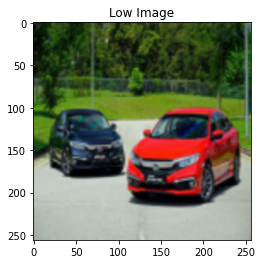

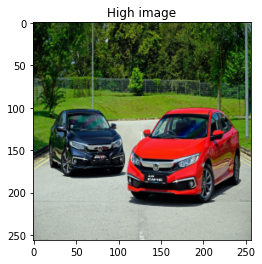

In [79]:
for low, high in zip(train_low_images[:1], train_high_images[:1]): 
    low_img = tf.io.read_file(low) 
    low_img = tf.image.decode_jpeg(low_img)
    
    high_img = tf.io.read_file(high) 
    high_img = tf.image.decode_jpeg(high_img)
    
    # print(type(low_img))
    plt.title('Low Image')
    plt.imshow(low_img)
    plt.show()
    
    plt.title('High image')
    plt.imshow(high_img)
    plt.show() 
    
    

In [80]:
def down(filters, kernel_size, apply_batch_noralization=True):
    downsample = tf.keras.models.Sequential()
    downsample.add(tf.keras.layers.Conv2D(filters, kernel_size, padding='same', strides=2))
    
    if apply_batch_noralization:
        downsample.add(tf.keras.layers.BatchNormalization())
    
    downsample.add(tf.keras.layers.LeakyReLU())
    
    return downsample

def up(filters, kernel_size, dropout=False):
    upsample = tf.keras.models.Sequential() 
    upsample.add(tf.keras.layers.Conv2DTranspose(filters, kernel_size, padding='same', strides=2))
    
    if dropout:
        upsample.add(tf.keras.layers.Dropout(0.2))
        
    upsample.add(tf.keras.layers.LeakyReLU())
    
    return upsample 

def create_model():
    inputs = tf.keras.Input(shape=(256, 256, 3))
    
    x1 = down(128, (3, 3), False)(inputs)
    x2 = down(128, (3, 3), False)(x1)
    x3 = down(256, (3, 3), True)(x2)
    x4 = down(512, (3, 3), True)(x3)
    x5 = down(512, (3, 3), True)(x4)
    
    x6 = up(512, (3, 3), True)(x5)
    x7 = tf.keras.layers.concatenate([x6, x4])
    
    x8 = up(256, (3, 3), True)(x7)
    x9 = tf.keras.layers.concatenate([x8, x3])
    
    x10 = up(128, (3, 3), True)(x9)
    x11 = tf.keras.layers.concatenate([x10, x2])
    
    x12 = up(128, (3, 3), True)(x11)
    x13 = tf.keras.layers.concatenate([x12, x1])
    
    x14 = up(3, (3, 3), True)(x13)
    x15 = tf.keras.layers.concatenate([x14, inputs])
    
    outputs = tf.keras.layers.Conv2D(3, (2, 2), strides=1, padding='same')(x15)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)
    

model = create_model() 
model.summary()     

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_17 (Sequential)     (None, 128, 128, 12  3584        ['input_4[0][0]']                
                                8)                                                                
                                                                                                  
 sequential_18 (Sequential)     (None, 64, 64, 128)  147584      ['sequential_17[0][0]']          
                                                                                            

In [81]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_absolute_error', metrics=['accuracy'])

In [82]:
hist = model.fit(low_train_images, high_train_images, epochs=7, batch_size=1, validation_data=(low_test_images, high_test_images))

Epoch 1/7
685/685 [==============================] - 19s 24ms/step - loss: 0.1803 - accuracy: 0.5286 - val_loss: 0.4784 - val_accuracy: 0.3373
Epoch 2/7
685/685 [==============================] - 16s 23ms/step - loss: 0.1110 - accuracy: 0.6205 - val_loss: 0.4783 - val_accuracy: 0.3575
Epoch 3/7
685/685 [==============================] - 16s 23ms/step - loss: 0.1020 - accuracy: 0.6267 - val_loss: 0.4605 - val_accuracy: 0.2965
Epoch 4/7
685/685 [==============================] - 16s 23ms/step - loss: 0.0958 - accuracy: 0.6294 - val_loss: 0.4824 - val_accuracy: 0.3189
Epoch 5/7
685/685 [==============================] - 16s 23ms/step - loss: 0.0910 - accuracy: 0.6307 - val_loss: 0.4821 - val_accuracy: 0.2848
Epoch 6/7
685/685 [==============================] - 16s 23ms/step - loss: 0.0884 - accuracy: 0.6362 - val_loss: 0.4887 - val_accuracy: 0.3207
Epoch 7/7
685/685 [==============================] - 16s 23ms/step - loss: 0.0867 - accuracy: 0.6438 - val_loss: 0.4920 - val_accuracy: 0.3440

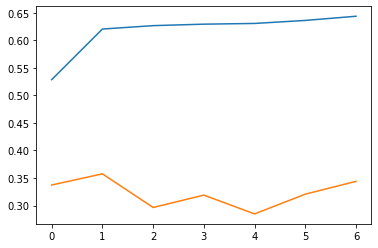

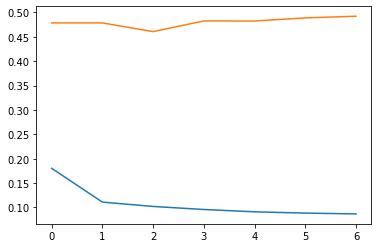

In [85]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.show() 

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show() 

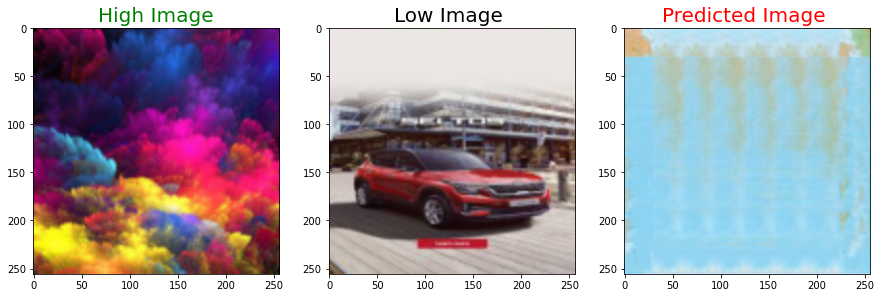

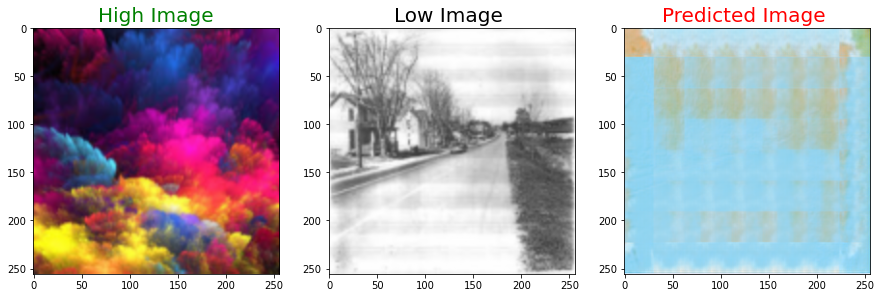

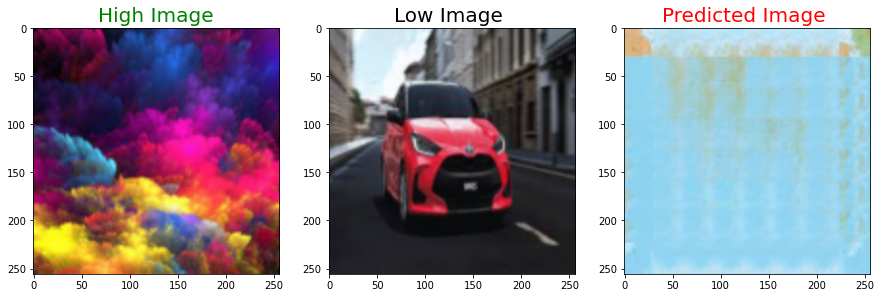

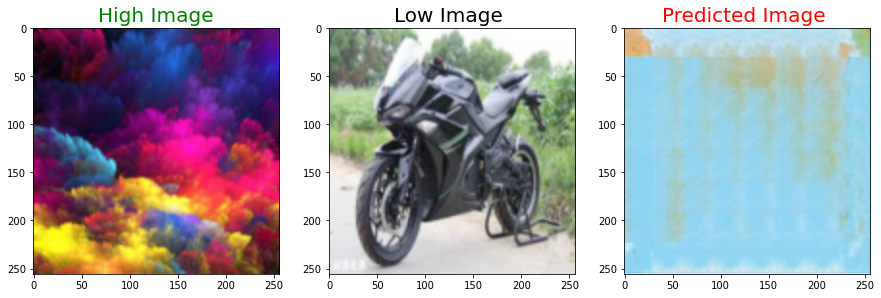

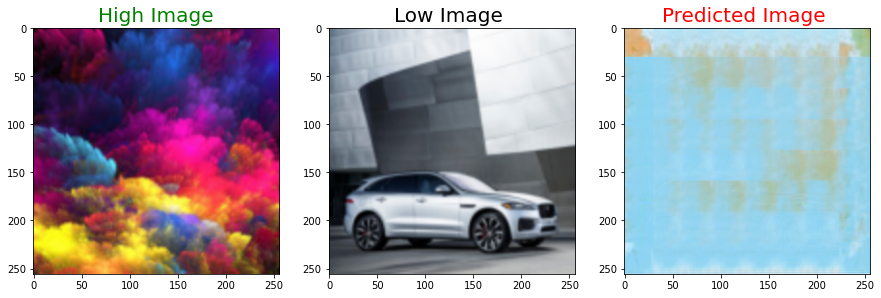

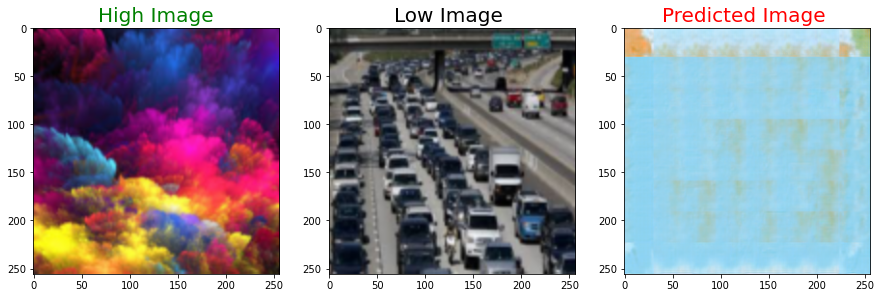

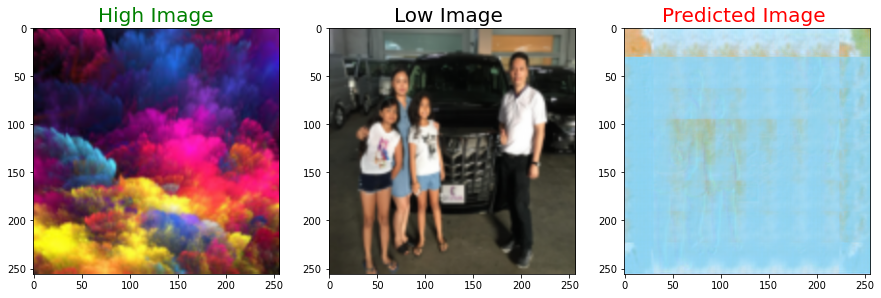

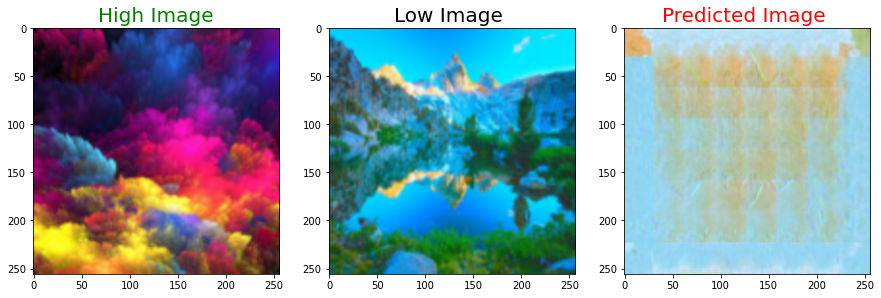

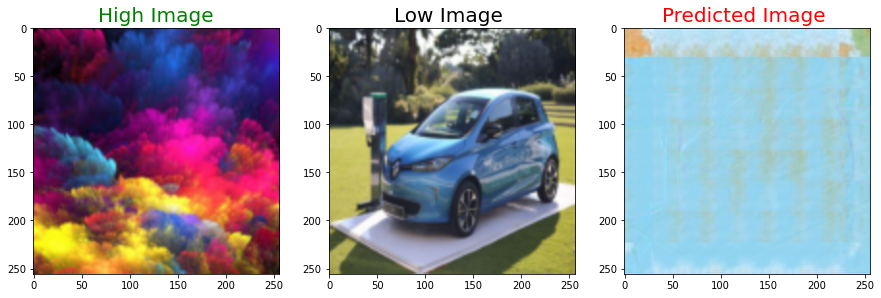

In [84]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(1,10):
    
    predicted = np.clip(model.predict(low_test_images[i].reshape(1,256, 256,3)),0.0,1.0).reshape(256, 256,3)
    plot_images(high_test_images[i], low_test_images[i],predicted)